In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
#from datetime import datetime
import matplotlib.dates as mdates

C:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
datetime.date(2014,10,15)

datetime.date(2014, 10, 15)

## Bring in data

In [3]:
#the earliest common time
ECT = '2014-11-08 00:00:00'
#the latest common time
LCT = '2015-02-11 00:00:00'
DailyTempDiff = pd.read_pickle('.\DataFrames/DayTimeMeanSurfaceTemp.pkl')
DailyTempDiff.sort_index(axis=1,inplace=True)
HourlyWateruse = pd.read_pickle('.\DataFrames/HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames/TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
SHFData = pd.read_pickle('.\DataFrames/HourlySoilHeatFluxTotalMJ.pkl')
SHFData.sort_index(axis=0,inplace=True)
RnDF = pd.read_pickle('.\DataFrames/NetRadiationMJ.pkl').loc[pd.IndexSlice[:,:,:,ECT:]]
RnDF.sort_index(axis=0,inplace=True)

#Bring in estimated upper and lower canopy temp limits
HourlyTsBounds = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')#pd.read_pickle('.\DataFrames\TsBoundData.pkl')
HourlyTsBounds.index.name = 'Date'


Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1013 #Heat capacity of air Joule/kg/oC
D0 = 4000#1200
D6 = 2000
DB = 4
E = -0.0005
C1 = 1.2
C0 = 2.0
CB = 0.6
##Contract dataframes down to common index size
HourlyWateruse = HourlyWateruse.loc[ECT:LCT,:]
TnRData = TnRData.loc[ECT:LCT,:]
TnRData.index.name='Date'

HourlyWateruse.columns = HourlyWateruse.columns.swaplevel(0,1)

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
IrrigationsSub = ['High','Low']
DetailsPlotsList = [('Dash','High','1'),('Dash','High','3'),('Dash','High','4'),
          ('Dash','Low','1'),('Dash','Low','3'),('Dash','Low','4'),
          ('Omaka','High','1'),('Omaka','High','3'),('Omaka','High','4'),
          ('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','4')]

PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

# Clean up all the crap

In [4]:
#Create a list of time to exclude where irrigation applications caused noise
IrrigationDates = pd.to_datetime(['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14'])
#Remove data from daily dataframes
#DailyWaterUse = DailyWaterUse.loc[~DailyWaterUse.index.isin(IrrigationDates)]
DailyTempDiff = DailyTempDiff.loc[~DailyTempDiff.index.isin(IrrigationDates)]
#Make hourly exclusion index and remove data from hourly data frames
IrrigationDateTimes = []
for irrigDate in IrrigationDates:
    IrrigationDateTimes += pd.date_range(irrigDate,periods=24,freq='H')
HourlyWateruse = HourlyWateruse.loc[~HourlyWateruse.index.isin(IrrigationDateTimes)]
#Make 15 min exclusion index and remove data from 15min data frames
IrrigationDateTimes15 = []
for irrigDate in IrrigationDates:
    IrrigationDateTimes15 += pd.date_range(irrigDate,periods=96,freq='15T')
SHFData = SHFData.loc[~SHFData.index.isin(IrrigationDateTimes15,level=3)]
#Make 5 min exclusion index and remoe data from 5min data frames
IrrigationDateTimes5 = []
for irrigDate in IrrigationDates:
    IrrigationDateTimes5 += pd.date_range(irrigDate,periods=288,freq='5T')
TnRData = TnRData.loc[~TnRData.index.isin(IrrigationDateTimes5)]

In [5]:
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
DailyWaterUse = HourlyWateruse.resample('d').sum()
DailyWaterUse = DailyWaterUse.loc[~DailyWaterUse.index.isin(NoMeasurementDates)]
DailyWaterUse = DailyWaterUse.reindex(DailyTempDiff.index) * -1
DailyWaterUse.sort_index(axis=0,inplace=True)
DailyWaterUse.sort_index(axis=1,inplace=True)

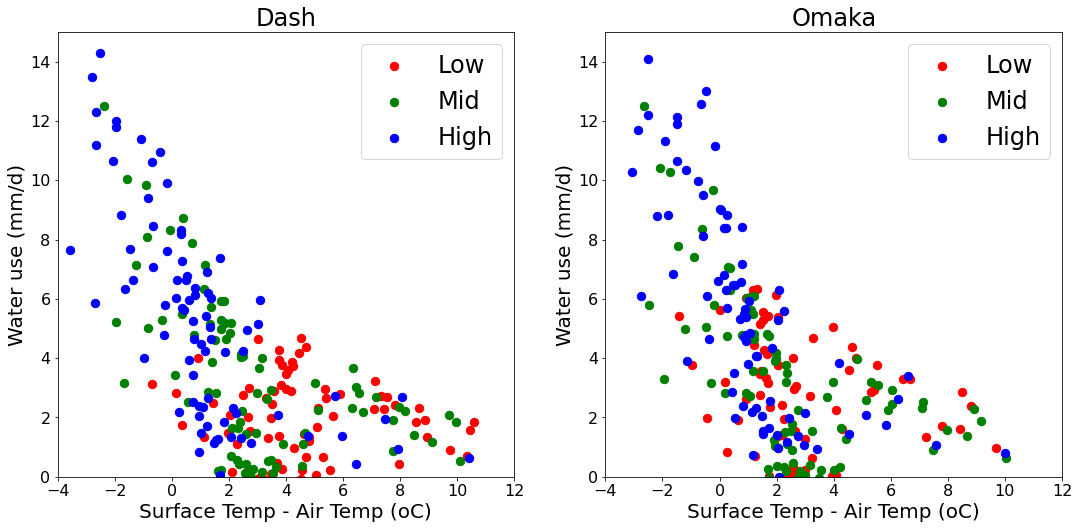

In [6]:
Comparison = plt.figure(figsize = (18,18))

Colors = ['red', 'green', 'blue']
Position = 1
for Cultivar in Cultivars:
    fig = Comparison.add_subplot(2,2,Position)
    ColorPosition = 0   
    for Irrigation in Irrigations:
        plt.scatter(DailyTempDiff.loc[:,('TsTa',Cultivar,Irrigation)],
                 DailyWaterUse.loc[:,(Irrigation,Cultivar)].mean(axis=1), 
                 color = Colors[ColorPosition],
                 label = Irrigation,
                 s = 70)
        ColorPosition += 1
    plt.ylabel('Water use (mm/d)', fontsize= 20)
    plt.xlabel('Surface Temp - Air Temp (oC)', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(0,15)
    plt.xlim(-4,12)
    plt.legend(fontsize = 24)
    plt.title(Cultivar, fontsize = 24)
    Position +=1

## Make a data frame with hourly mean energy balance data in W/m2

### Bring in the cover Data

Text(0, 0.5, 'Cover Green')

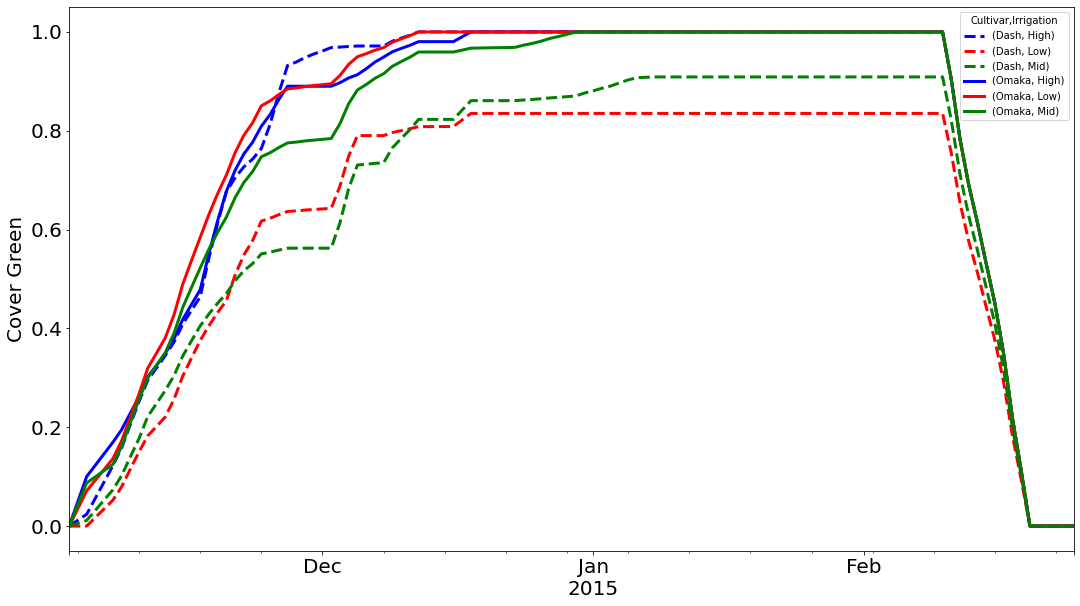

In [7]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

Text(0, 0.5, 'Cover Green')

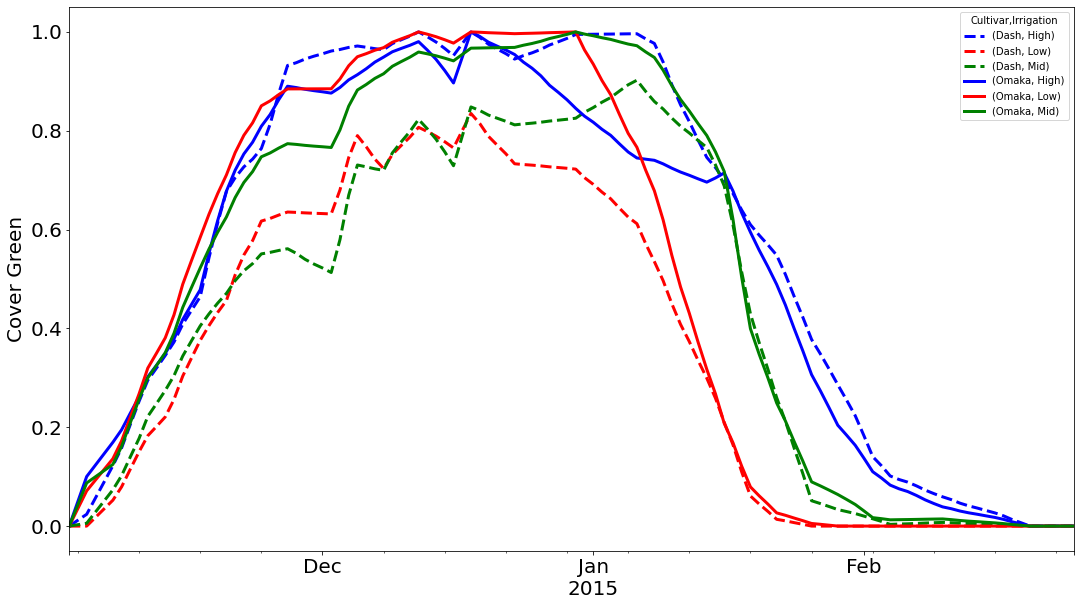

In [8]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

In [9]:
def makeSeries(Var,Frame):
    SSeries= Frame.loc[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [10]:
import math as math #import library for math functions
def RaZot(WindSpeed, Zu, h, Zot_Zom):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    d = (0.63*h)  # is the zero displacement height which is a complex function of canopy height and archicture
    Zot = (0.13*h) * Zot_Zom # is the roughness length of temperature and is also influenced by canopy height and archicture
    LN = math.log((Zu-d)/Zot)
    _ret = math.pow(LN,2)/(0.16*WindSpeed)
    return _ret 

In [11]:
HourlyWateruse.columns.swaplevel('Irrigation','Cultivar')

MultiIndex([( 'Dash', 'High', '1'),
            ( 'Dash', 'High', '2'),
            ( 'Dash', 'High', '3'),
            ( 'Dash', 'High', '4'),
            ( 'Dash',  'Low', '1'),
            ( 'Dash',  'Low', '2'),
            ( 'Dash',  'Low', '3'),
            ( 'Dash',  'Low', '4'),
            ( 'Dash',  'Mid', '1'),
            ( 'Dash',  'Mid', '2'),
            ( 'Dash',  'Mid', '3'),
            ( 'Dash',  'Mid', '4'),
            ('Omaka', 'High', '1'),
            ('Omaka', 'High', '2'),
            ('Omaka', 'High', '3'),
            ('Omaka', 'High', '4'),
            ('Omaka',  'Low', '1'),
            ('Omaka',  'Low', '2'),
            ('Omaka',  'Low', '3'),
            ('Omaka',  'Low', '4'),
            ('Omaka',  'Mid', '1'),
            ('Omaka',  'Mid', '2'),
            ('Omaka',  'Mid', '3'),
            ('Omaka',  'Mid', '4')],
           names=['Cultivar', 'Irrigation', 'Block'])

In [12]:
#Start off data frame with net radiation data W/m2
#need to make this measured Rn not estimated
RnDF.name = 'Rn'
EnergyBalance = pd.DataFrame(RnDF)
#SoilHeatFlux Data is in W/m2 so join into frame
EnergyBalance = EnergyBalance.join(SHFData)

#Make hourly water use long
HourlyWateruse.columns = HourlyWateruse.columns.swaplevel('Irrigation','Cultivar')
HourlyWateruse.index.name = 'Date'
HWULong = HourlyWateruse.unstack()
#Make hourly water use positive
PHWU = HWULong * -1
PHWU.name = 'PHWU'
#join into dataframe
EnergyBalance = EnergyBalance.join(PHWU)

#Get some other variables into dataframe
DateSet = EnergyBalance.loc[('Dash','Low','1'),:].index
TnRDataLong = TnRData.resample('h').mean().reindex(DateSet).unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)

for plot in DetailsPlotsList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    LESeries = np.multiply(EnergyBalance.loc[plot,'PHWU'], LamdaSeries)
    EnergyBalance.loc[plot,'HLEMJ'] = LESeries.values
    EnergyBalance.loc[plot,'Ta'] = tempSeries.values
    EnergyBalance.loc[plot,'u'] = windSeries.values
    EnergyBalance.loc[plot,'q'] = qSeries.values
    EnergyBalance.loc[plot,'VPD'] = VPDSeries.values
    EnergyBalance.loc[plot,'lamda'] = LamdaSeries.values

    
#then divide by duration (3600 seconds) to give latent heat in MW and divide by a million to convert to W
EnergyBalance.loc[:,'LE'] = EnergyBalance.loc[:,'HLEMJ']#/3600 * 1000000

#Calculate sensible heat and put into data frame
EnergyBalance.loc[:,'H'] = EnergyBalance.loc[:,'Rn'] - EnergyBalance.loc[:,'G'] - EnergyBalance.loc[:,'LE'] 

#Make the surface temperature data long and join into dataframe
TsDF = TnRData.reindex(index=DateSet)['IR_SurfaceTemp']
TsDF.columns = HourlyWateruse.sort_index(axis=1).columns
TsLong = TsDF.unstack()
TsLong.name= 'Ts'
EnergyBalance = EnergyBalance.join(TsLong)
EnergyBalance.loc[:,'uVPD'] = EnergyBalance.loc[:,'u'] * EnergyBalance.loc[:,'VPD']
EnergyBalance.loc[:,'Ts-Ta'] = EnergyBalance.loc[:,'Ts'] - EnergyBalance.loc[:,'Ta']
EnergyBalance.loc[:,'qCp'] = EnergyBalance.loc[:,'q']*Cp
EnergyBalance.loc[:,'Cover'] = CoverData.reindex(DateSet).bfill().unstack()
EnergyBalance.loc[:,'GreenCover'] = GreenCoverData.reindex(DateSet).bfill().unstack()
EnergyBalance.loc[:,'Rn-G'] = EnergyBalance.loc[:,'Rn'] - EnergyBalance.loc[:,'G']
EnergyBalance.loc[:,'H/(Rn-G)'] = EnergyBalance.loc[:,'H'] / EnergyBalance.loc[:,'Rn-G']
EnergyBalance.loc[:,'abs(H/(Rn-G))'] = EnergyBalance.loc[:,'H/(Rn-G)'].abs()
EnergyBalance.loc[:,'(Ts-Ta)qCp'] = EnergyBalance.loc[:,'Ts-Ta'] * (EnergyBalance.loc[:,'qCp'])
EnergyBalance.loc[:,'Ra'] =  (EnergyBalance.loc[:,'(Ts-Ta)qCp']*86400)/EnergyBalance.loc[:,'H']
#EnergyBalance.loc[:,'Ra'] = EnergyBalance.loc[:,'Ra'].abs()
EnergyBalance.loc[:,'abs(H/(Rn-G))/Ra'] = EnergyBalance.loc[:,'abs(H/(Rn-G))']/EnergyBalance.loc[:,'Ra']

#Join in estimated upper canopy temp limits
EnergyBalance.loc[:,'TsUL-Ta'] = HourlyTsBounds.resample('h').mean().reindex(DateSet).bfill().unstack()

#Calculate some more stuff
#EnergyBalance.loc[:,'(TsLL-Ta)qCp'] = np.multiply(EnergyBalance.loc[:,'TsLL-Ta'] , EnergyBalance.loc[:,'qCp'])
EnergyBalance.loc[:,'maxH/(Rn-G)'] = 1.0 - EnergyBalance.loc[:,'GreenCover']*-0.4 
EnergyBalance.loc[:,'depH/(Rn-G)'] = EnergyBalance.loc[:,'maxH/(Rn-G)'] - EnergyBalance.loc[:,'H/(Rn-G)']
EnergyBalance.loc[:,'(TsUL-Ta)qCp'] = np.multiply(EnergyBalance.loc[:,'TsUL-Ta'] , EnergyBalance.loc[:,'qCp'])
EnergyBalance.loc[:,'TsUL'] = EnergyBalance.loc[:,'Ta'] + EnergyBalance.loc[:,'TsUL-Ta']
EnergyBalance.loc[:,'ToUL'] = EnergyBalance.loc[:,'TsUL'] + EnergyBalance.loc[:,'VPD'] * 1
EnergyBalance.loc[:,'ToUL-Ta'] = EnergyBalance.loc[:,'ToUL'] - EnergyBalance.loc[:,'Ta']
EnergyBalance.loc[:,'(ToUL-Ta)qCp'] = np.multiply(EnergyBalance.loc[:,'ToUL-Ta'] , EnergyBalance.loc[:,'qCp'])

EnergyBalance.loc[:,'To'] = EnergyBalance.loc[:,'Ts'] + EnergyBalance.loc[:,'VPD'] * 1
EnergyBalance.loc[:,'To-Ta'] = EnergyBalance.loc[:,'To'] - EnergyBalance.loc[:,'Ta']
EnergyBalance.loc[:,'(To-Ta)qCp'] = EnergyBalance.loc[:,'To-Ta'] * EnergyBalance.loc[:,'qCp']
EnergyBalance.loc[:,'(Ts-Ta)/(TsUL-Ta)'] = EnergyBalance.loc[:,'Ts-Ta'] / EnergyBalance.loc[:,'TsUL-Ta']
EnergyBalance.loc[:,'(To-Ta)/(ToUL-Ta)'] = EnergyBalance.loc[:,'To-Ta'] / EnergyBalance.loc[:,'ToUL-Ta']
EnergyBalance.loc[:,'(To-Ta)aCp/(ToUL-Ta)qCp'] = EnergyBalance.loc[:,'(To-Ta)qCp'] / EnergyBalance.loc[:,'(ToUL-Ta)qCp']
EnergyBalance.loc[:,'ulim'] = [max(EnergyBalance.loc[x,'u'],1) for x in EnergyBalance.loc[:,'u'].index]
EnergyBalance.loc[:,'Ra'] = 1/(0.015 * EnergyBalance.loc[:,'ulim'])
EnergyBalance.loc[:,'EstH'] = (((EnergyBalance.loc[:,'qCp']/1e6)/EnergyBalance.loc[:,'Ra'])*86400 * EnergyBalance.loc[:,'To-Ta'])/EnergyBalance.loc[:,'lamda']/25
EnergyBalance.loc[:,'H/lamda'] = EnergyBalance.loc[:,'H']/EnergyBalance.loc[:,'lamda']

In [13]:
import math as math #import library for math functions
def RaFAO(WindSpeed, h):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    left = np.log((2-(2/3)*h)/(0.123*h))
    right =  np.log((2-(2/3)*h)/(0.1* 0.123*h))
    denom = 0.42**2*WindSpeed
    _ret = (left*right)/denom
        
    return _ret 

In [14]:
RaFAO(1,0.12)

197.8930281651121

In [15]:
208.0/1

208.0

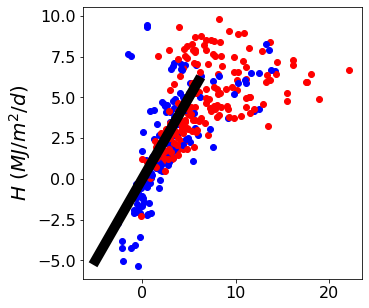

In [16]:
Comparison = plt.figure(figsize = (5,5))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).mean().resample('d').sum()
        #Upp = yData + ySEM
        #Low = yData - ySEM
        #xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, 'o', color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        #plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    #plt.ylim(-17,25)
    LinePos +=1
    #fig.xaxis.set_major_locator(mdates.MonthLocator())
    #fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    #plt.xlim('2014-11-01','2015-02-15')
    #plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2
factor = 1
xs = [-5*factor,6*factor]
plt.plot(xs,np.divide(xs,factor),'-',linewidth=10,color='k')



In [17]:
datetime.date(2014,1,1)

datetime.date(2014, 1, 1)

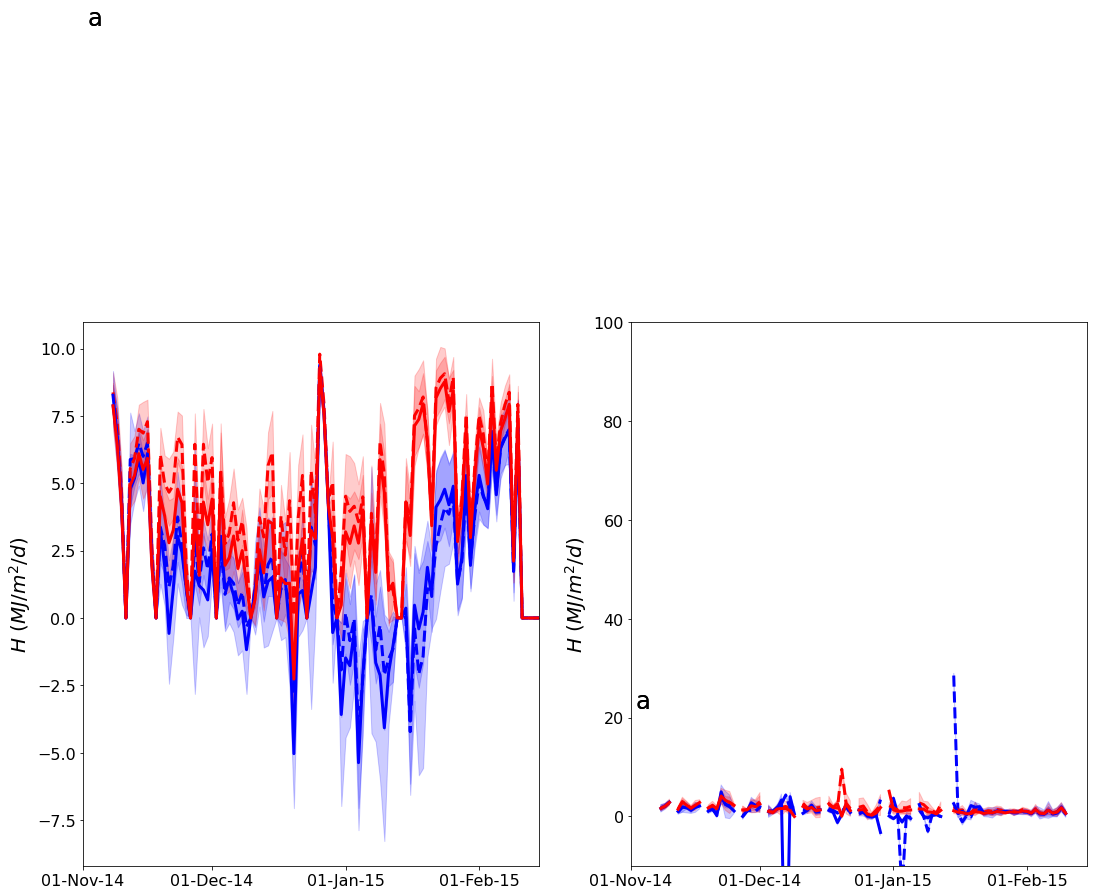

In [18]:
Comparison = plt.figure(figsize = (18,10))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,2,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    #plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim(datetime.date(2014,11,1),datetime.date(2015,2,15))
    plt.text(datetime.date(2014,11,2),22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(1,2,2)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        denom = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/lamda'].groupby(level='Date',axis=0).mean().resample('d').sum()
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).mean().resample('d').sum()/denom
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-10,100)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim(datetime.date(2014,11,1),datetime.date(2015,2,15))
    plt.text(datetime.date(2014,11,2),22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2



ConversionError: Failed to convert value(s) to axis units: '2014-11-01'

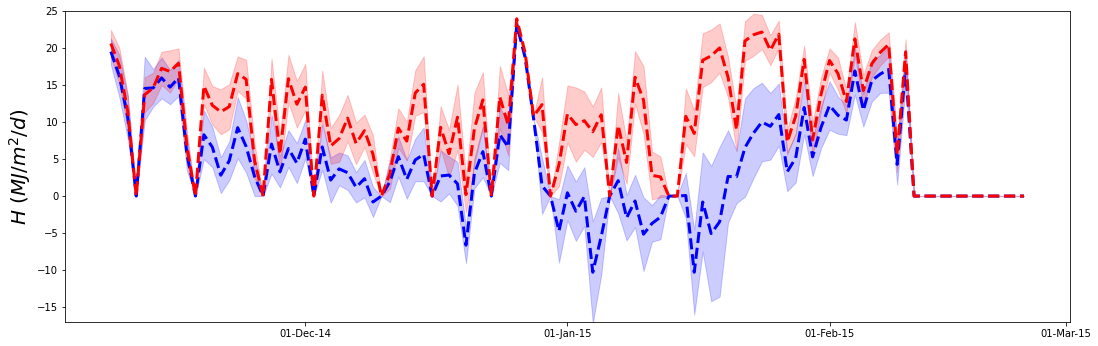

In [19]:
# A)
Comparison = plt.figure(figsize = (18,40))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(6,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.05 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

# B)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.xlabel('$Rn-G$ $(MJ/m^2/d)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-15,25)
    plt.xlim(0,25)
    plt.text(0.1,22, 'b', fontsize = 24)
    plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
Position +=1

# C)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_s-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 0.95, 'c', fontsize = 24)
Position +=1

# D)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(To-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_o-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 0.95, 'd', fontsize = 24)
Position +=1
plt.plot([-7000,7000],[-1,1],'-',color='k',linewidth=3)


# E)
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0) & (EnergyBalance.loc[:,'(To-Ta)/(ToUL-Ta)']>-10)\
        &(EnergyBalance.loc[:,'(Ts-Ta)/(TsUL-Ta)']<2)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(To-Ta)/(ToUL-Ta)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_o-T_a) / (T_{oUL}-T_a)$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-2,2)
plt.text(-1.9, 0.95, 'e', fontsize = 24)
Position +=1
plt.plot([-1.,1.7],[-0.55,0.935],'-',color='k',linewidth=3)

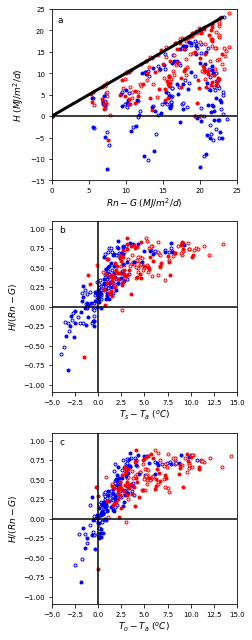

In [22]:
Comparison = plt.figure(figsize = (3.6,9))
# A)
fig = Comparison.add_subplot(3,1,1)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=3,mew=1)
        ColorPosition += 1
        FillPosition += 1
plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 9)
plt.xlabel('$Rn - G$ $(MJ/m^2/d)$', fontsize= 9)
plt.ylim(-15,25)
plt.xlim(0,25)
plt.text(0.8,22, 'a', fontsize = 9)
plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
plt.plot([0,25],[0,0],'-',color='k')
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=7)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=7)
fig.xaxis.labelpad = 2

# B)
fig = Comparison.add_subplot(3,1,2)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Ts-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=3,mew=1)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1.1,1.1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$H/(Rn-G)$', fontsize= 9)
plt.xlabel(r'$T_s-T_a \/\/(^oC)$', fontsize= 9)
plt.ylim(-1.1,1.1)
plt.xlim(-5,15)
plt.text(-4.2, 0.95, 'b', fontsize = 9)
Position +=1
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=7)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=7)
fig.xaxis.labelpad = 2

# c)
fig = Comparison.add_subplot(3,1,3)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=3,mew=1)
        ColorPosition += 1
        FillPosition += 1
plt.plot([0,0],[-1.1,1.1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$H/(Rn-G)$', fontsize= 9)
plt.xlabel(r'$T_o-T_a\/\/(^oC)$', fontsize= 9)
plt.ylim(-1.1,1.1)
plt.xlim(-5,15)
plt.text(-4.2, 0.95, 'c', fontsize = 9)
Position +=1
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=7)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=7)
fig.xaxis.labelpad = 2
plt.tight_layout()
Comparison.savefig('Fig_7.png',dpi=1000)
#Comparison.savefig('Fig_7.eps',dpi=1000)

In [ ]:
Graph = plt.figure(figsize=(18,10))
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Pos = 3
for Cult in ['Dash']:#Cultivars:
    for Irr in ['Low']:#IrrigationsSub:
        HData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'H'].loc['2015-01-07':'2015-01-12']
        LEData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'LE'].loc['2015-01-07':'2015-01-12']
        RnData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'Rn'].loc['2015-01-07':'2015-01-12']
        GData = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'G'].loc['2015-01-07':'2015-01-12']
        xData = HData.index
        plt.plot(xData,HData,lines[Pos],color='r',linewidth=Widths[Pos])
        plt.plot(xData,LEData,lines[Pos],color='b',linewidth=Widths[Pos])
        plt.plot(xData,RnData,lines[Pos],color='orange',linewidth=Widths[Pos])
        plt.plot(xData,GData,lines[Pos],color='g',linewidth=Widths[Pos])
        Pos+=1

In [ ]:
Graph = plt.figure(figsize=(18,10))
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Dates = ['2015-01-07','2015-01-30']
Pos = 3
for Cult in ['Dash']:#Cultivars:
    for Irr in ['High']:#IrrigationsSub:
        TsTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'Ts-Ta'].loc[Dates[0]:Dates[1]]
        ToTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'To-Ta'].loc[Dates[0]:Dates[1]]
        TsULTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'TsUL-Ta'].loc[Dates[0]:Dates[1]]
        ToULTa = EnergyBalance.groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'ToUL-Ta'].loc[Dates[0]:Dates[1]]
        xData = TsTa.index
        plt.plot(xData,TsTa,'-',color='r',linewidth=Widths[Pos])
        plt.plot(xData,ToTa,'-',color='g',linewidth=Widths[Pos])
        plt.plot(xData,TsULTa,'--',color='r',linewidth=Widths[Pos])
        plt.plot(xData,ToULTa,'--',color='g',linewidth=Widths[Pos])
        Pos+=1

In [ ]:
EnergyBalance.columns

In [ ]:
Graph = plt.figure(figsize=(18,10))
Colors = ['red','green','blue']
lines = ['--','--','-','-']
Widths = [1,2,1,2]
Dates = ['2015-01-07','2015-01-30']
Pos = 0
Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)
for Cult in ['Dash']:#Cultivars:
    for Irr in ['High']:
        ToTa = EnergyBalance.loc[Filter].groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'To-Ta'].resample('d').mean()
        ToULTa = EnergyBalance.loc[Filter].groupby(level=['Cultivar','Irrigation','Date'],axis=0).mean().loc[(Cult,Irr),'ToUL-Ta'].resample('d').mean()
        xData = ToTa.index
        plt.plot(xData,ToTa,'--',color=Colors[Pos],linewidth=Widths[Pos])
        plt.plot(xData,ToULTa,'-',color=Colors[Pos],linewidth=Widths[Pos])
        Pos+=1


In [ ]:
fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.2)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        #yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()/EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = yData.index
        plt.plot(xData,yData,'-', color =  Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1


In [ ]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['Rn','G','LE','H','Ts-Ta','To-Ta','ToUL-Ta','(To-Ta)/(ToUL-Ta)','Cover','u','GreenCover','H/(Rn-G)']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0.1 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1


In [ ]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['(To-Ta)/(ToUL-Ta)']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'To-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()/EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ToUL-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(-1,2)

In [ ]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['To-Ta']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(-4,12)

In [ ]:
Comparison = plt.figure(figsize = (20,60))

Colors = ['blue','red','green']
Variables = ['ToUL-Ta']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(10,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in IrrigationsSub:
            Filter = EnergyBalance.Rn > 0 
            yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean().resample('d').mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    if Position == 10:
        plt.ylim(-1,2)
    plt.title(Var, fontsize = 24)
    Position +=1
plt.ylim(1,15)

In [ ]:
Comparison = plt.figure(figsize = (18,40))
Tit = ['a','b','c','d','e','f','g','h','i','j','k']
Colors = ['blue','red']
FillColors = ['White','White','blue','red']
Lines = ['--','-']
Position = 1
fig = Comparison.add_subplot(6,1,Position)
LinePos=0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = EnergyBalance.Rn > 0.01 
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        ySEM = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).std().resample('d').sum()
        Upp = yData + ySEM
        Low = yData - ySEM
        xData = yData.index.get_level_values('Date')
        plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation,linewidth = 3)
        plt.fill_between(xData,Upp,Low,color = Colors[ColorPosition],alpha=0.2)
        ColorPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.ylim(-17,25)
    LinePos +=1
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.xlim('2014-11-01','2015-02-15')
    plt.text('2014-11-02',22, 'a', fontsize = 24)
plt.tick_params(labelsize = 16)
Position +=2

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H'].groupby(level='Date',axis=0).mean().resample('d').sum()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Rn-G'].groupby(level='Date',axis=0).mean().resample('d').sum()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel('$H$ $(MJ/m^2/d)$', fontsize= 20)
    plt.xlabel('$Rn-G$ $(MJ/m^2/d)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-15,25)
    plt.xlim(0,25)
    plt.text(0.1,22, 'b', fontsize = 24)
    plt.plot([0,23],[0,23],'-',color='k',linewidth=3)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0.0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'H/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
# yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'EstH/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('h').mean()
# xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'(Ts-Ta)qCp'].groupby(level='Date',axis=0).mean().resample('h').mean()
# plt.plot(xData,yData,'o', mec = 'm', mfc = 'm', label = Irrigation,markersize=2,mew=2)
Xs = range(-6000,14000,200)
Ys1 = []
Ys0 = []
for x in Xs:
    y1 = 2/(1+np.exp((x+-2000)*-.0002)) - (2/2)
    y0 = C0/(1+np.exp((x+0)*-.001)) - (C0/2)
    Ys1.append(y1)
    Ys0.append(y0)
plt.plot(Xs,Ys1,'-',color='m',linewidth=4)
#plt.plot(Xs,Ys0,'-',color='c',linewidth=4)
plt.plot([0,0],[-1,1],'k')
plt.plot([-15000,15000],[0,0],'k')
plt.ylabel(r'$\beta $', fontsize= 20)
plt.xlabel(r'$(T_s-T_a) \rho Cp$', fontsize= 20)
plt.tick_params(labelsize = 16)
plt.ylim(-1.1,1.1)
plt.xlim(-5000,15000)
plt.text(-4700, 1.2, 'c', fontsize = 24)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .5)&(EnergyBalance.LE > .1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)&(EnergyBalance.loc[:,'uVPD']>6)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ResH/(Rn-G)'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'u'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel(r'$res(\beta)$', fontsize= 20)
    plt.xlabel('$fPAR_{green}$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-2,2)
    #plt.xlim(0,1)
    #plt.plot([0,CB,1],[(C0-C1)/2,0,0],'-',color='k',linewidth=2)
    plt.plot([0,0.8,1],[.4,-0.1,-0.1],'-',color='k',linewidth=2)
    #yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'C'].groupby(level='Date',axis=0).mean().resample('d').mean()/2 - C1/2
    #xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean().resample('d').mean()
    #plt.plot(xData,yData,'-', mec = 'm', mfc = 'm', label = Irrigation,markersize=2,mew=2)
    plt.text(0.02, 0.8, 'd', fontsize = 24)
Position +=1

fig = Comparison.add_subplot(6,2,Position)
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0   
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.Rn > .5)&(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <1.05)\
        &(EnergyBalance.loc[:,'Cover']>0.7)&(EnergyBalance.LE>0.1)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'ResH/(Rn-G)2'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'uVPD'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
    plt.ylabel(r'$res(\beta)$', fontsize= 20)
    plt.xlabel('$Wind$ $speed$ $(m/s)$', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(-1,1)
    plt.plot([0,4,8],[.5,0,0],'-',color='k',linewidth=2)
    #plt.text(0.2, 0.8, 'e', fontsize = 24)
Position +=1

In [ ]:
EnergyBalance.to_csv('.\DataFrames\EnergyBalanceData.csv')

## Look at sensible heat data in relation to canopy temp depression

In [ ]:
Descriptors = ['Ts-TaqCp','GreenCover']
Filter = (EnergyBalance.Rn > 0.6)#&(EnergyBalance.Ra <300)&(EnergyBalance.Ra>2)
X = EnergyBalance.loc[Filter,EnergyBalance.columns.isin(Descriptors)]
Y = EnergyBalance.loc[Filter,'H/(Rn-G)']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

In [ ]:
fig = plt.Figure()
FillPosition = 0
for Cultivar in Cultivars:
    ColorPosition = 0 
    for Irrigation in IrrigationsSub:
        Filter = (EnergyBalance.loc[:,'Rn-G'] > 0.5)&(EnergyBalance.loc[:,'LE'] > 0.1)\
        &(EnergyBalance.loc[:,'abs(H/(Rn-G))'] <0.05)&(EnergyBalance.loc[:,'uVPD']>0)\
        &(EnergyBalance.GreenCover>0)
        yData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'Ts-Ta'].groupby(level='Date',axis=0).mean().resample('d').mean()
        xData = EnergyBalance.loc[Filter].loc[(Cultivar,Irrigation),'VPD'].groupby(level='Date',axis=0).mean().resample('d').mean()
        plt.plot(xData,yData,'o', mec = Colors[ColorPosition], mfc = FillColors[FillPosition], label = Irrigation,markersize=10,mew=2)
        ColorPosition += 1
        FillPosition += 1
#plt.plot([0,3],[1500,-7500])